<a href="https://colab.research.google.com/github/christophergaughan/medical-imaging-pytorch/blob/main/06_Atrium_Segmentation_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Left Atrium Segmentation from Cardiac MRI

**What you'll learn:**
1. **3D Medical Images** — Working with volumetric NIfTI data
2. **U-Net Architecture** — The gold standard for medical image segmentation
3. **Dice Loss** — Why cross-entropy isn't ideal for segmentation
4. **Data Augmentation** — Synchronized augmentation of images and masks
5. **Evaluation** — Dice score and visualization

**Why this matters:**
- Left atrial segmentation is clinically relevant for atrial fibrillation treatment planning
- U-Net is *the* architecture you'll see in medical imaging papers
- This is 3D cardiac MRI — directly relevant to MRI-focused roles

**Dataset:** [Medical Segmentation Decathlon - Task02_Heart](http://medicaldecathlon.com/)

**GPU Required:** Yes (for training)

---

## Table of Contents

1. [Part 1: Data Preprocessing](#part1)
   - Loading NIfTI cardiac MRI
   - Normalization and standardization
   - Slicing 3D volumes into 2D

2. [Part 2: Dataset & Augmentation](#part2)
   - PyTorch Dataset class
   - Synchronized image-mask augmentation

3. [Part 3: U-Net Architecture](#part3)
   - Encoder-decoder design
   - Skip connections explained

4. [Part 4: Training & Evaluation](#part4)
   - Dice Loss
   - Training loop
   - Visualization

---

## Setup

In [5]:
# Install dependencies
!pip install nibabel albumentations celluloid pytorch-lightning --quiet

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extract the dataset
import tarfile
from pathlib import Path

TAR_PATH = Path("/content/drive/MyDrive/AI_Medical_Images/06-Atrium-Segregation/Task02_Heart.tar")
EXTRACT_PATH = Path("/content/Task02_Heart")

if not EXTRACT_PATH.exists():
    print("Extracting Task02_Heart.tar...")
    with tarfile.open(TAR_PATH, 'r') as tar:
        tar.extractall('/content/')
    print("Done!")
else:
    print("Already extracted.")

!ls /content/Task02_Heart/

Extracting Task02_Heart.tar...


/tmp/ipython-input-3858671356.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('/content/')


Done!
dataset.json  imagesTr	imagesTs  labelsTr


In [6]:
# Core imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Medical imaging
import nibabel as nib

# Deep learning
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

# Augmentation
import albumentations as A

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB


In [7]:
# Set paths
DATA_ROOT = Path("/content/Task02_Heart")
IMAGES_DIR = DATA_ROOT / "imagesTr"
LABELS_DIR = DATA_ROOT / "labelsTr"
PROCESSED_DIR = Path("/content/Preprocessed")

print(f"Images: {len(list(IMAGES_DIR.glob('*.nii.gz')))} subjects")
print(f"Labels: {len(list(LABELS_DIR.glob('*.nii.gz')))} subjects")

Images: 21 subjects
Labels: 22 subjects


---
<a id='part1'></a>
# Part 1: Data Preprocessing

## Understanding the Data

**Task:** Segment the **left atrium** from cardiac MRI scans.

**Why the left atrium?**
- Atrial fibrillation (AFib) is the most common heart arrhythmia
- Treatment often involves ablation therapy
- Accurate LA segmentation helps plan ablation procedures
- Also used to measure LA volume (predictor of cardiovascular events)

**Data format:**
- NIfTI files (`.nii.gz`)
- 3D volumes: ~320 × 320 × 130 voxels
- Binary masks: 0 = background, 1 = left atrium

---

In [8]:
def change_img_to_label_path(path: Path) -> Path:
    """Convert image path to corresponding label path."""
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [9]:
# Load a sample subject
sample_path = list(IMAGES_DIR.glob("la_*"))[0]
sample_label_path = change_img_to_label_path(sample_path)

print(f"MRI: {sample_path.name}")
print(f"Mask: {sample_label_path.name}")

# Load NIfTI
mri_nii = nib.load(sample_path)
mask_nii = nib.load(sample_label_path)

mri = mri_nii.get_fdata()
mask = mask_nii.get_fdata().astype(np.uint8)

print(f"\nMRI shape: {mri.shape}")
print(f"MRI dtype: {mri.dtype}")
print(f"MRI range: [{mri.min():.1f}, {mri.max():.1f}]")
print(f"\nMask shape: {mask.shape}")
print(f"Mask unique values: {np.unique(mask)}")
print(f"\nOrientation: {nib.aff2axcodes(mri_nii.affine)}")

MRI: la_007.nii.gz
Mask: la_007.nii.gz

MRI shape: (320, 320, 130)
MRI dtype: float64
MRI range: [0.0, 1873.0]

Mask shape: (320, 320, 130)
Mask unique values: [0 1]

Orientation: ('R', 'A', 'S')


### Visualize the 3D Volume

Let's scroll through the sagittal slices to see the heart and the left atrium mask.

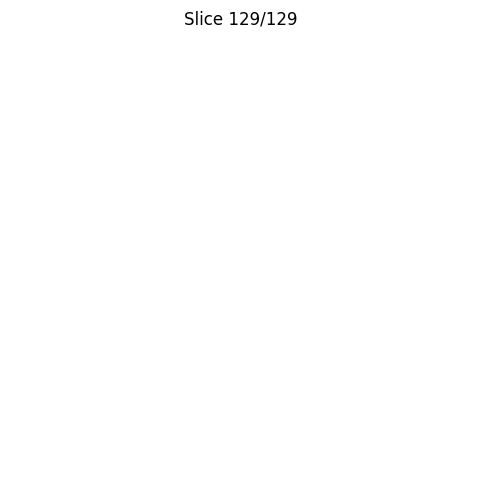

In [10]:
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)

for i in range(mri.shape[2]):  # Sagittal view (3rd axis)
    plt.imshow(mri[:, :, i], cmap="bone")
    mask_slice = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_slice, alpha=0.5, cmap="autumn")
    plt.title(f"Slice {i}/{mri.shape[2]-1}")
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

### Preprocessing Pipeline

We need to:

1. **Crop** — Remove empty space around the heart (32px from each side)
2. **Normalize** — Z-score normalization per subject
3. **Standardize** — Scale to [0, 1] range
4. **Slice** — Extract 2D slices for 2D U-Net training

**Why 2D slices instead of 3D?**
- Simpler architecture
- Less GPU memory
- Works well when slices are relatively independent
- 3D U-Net exists but requires more resources

In [11]:
def normalize(volume: np.ndarray) -> np.ndarray:
    """
    Z-score normalization of the whole 3D volume.

    For MRI, we normalize per-subject because intensities
    vary between scans (unlike CT with Hounsfield units).
    """
    mu = volume.mean()
    std = volume.std()
    return (volume - mu) / std


def standardize(volume: np.ndarray) -> np.ndarray:
    """
    Scale normalized data to [0, 1] range.

    This makes the data suitable for neural network input.
    """
    v_min, v_max = volume.min(), volume.max()
    return (volume - v_min) / (v_max - v_min)

In [12]:
def preprocess_and_save(
    images_dir: Path,
    save_dir: Path,
    train_split: int = 17,
    crop_size: int = 32
):
    """
    Preprocess all subjects and save as 2D numpy slices.

    Directory structure:
        Preprocessed/
        ├── train/
        │   ├── 0/
        │   │   ├── data/
        │   │   │   ├── 0.npy, 1.npy, ...
        │   │   └── masks/
        │   │       ├── 0.npy, 1.npy, ...
        │   └── 1/, 2/, ...
        └── val/
            └── 17/, 18/, ...

    Args:
        images_dir: Path to imagesTr folder
        save_dir: Where to save preprocessed data
        train_split: First N subjects for training
        crop_size: Pixels to crop from each side
    """
    all_files = sorted(images_dir.glob("la_*.nii.gz"))
    print(f"Found {len(all_files)} subjects")

    for idx, mri_path in enumerate(tqdm(all_files, desc="Preprocessing")):
        # Load MRI and mask
        label_path = change_img_to_label_path(mri_path)

        mri_nii = nib.load(mri_path)
        mri = mri_nii.get_fdata()
        mask = nib.load(label_path).get_fdata().astype(np.uint8)

        # Verify orientation
        assert nib.aff2axcodes(mri_nii.affine) == ('R', 'A', 'S'), \
            f"Unexpected orientation for {mri_path.name}"

        # Crop (remove empty space)
        mri = mri[crop_size:-crop_size, crop_size:-crop_size, :]
        mask = mask[crop_size:-crop_size, crop_size:-crop_size, :]

        # Normalize and standardize
        mri = standardize(normalize(mri))

        # Determine train/val split
        split = "train" if idx < train_split else "val"
        subject_dir = save_dir / split / str(idx)

        # Save each 2D slice
        data_dir = subject_dir / "data"
        mask_dir = subject_dir / "masks"
        data_dir.mkdir(parents=True, exist_ok=True)
        mask_dir.mkdir(parents=True, exist_ok=True)

        for slice_idx in range(mri.shape[2]):
            np.save(data_dir / f"{slice_idx}.npy", mri[:, :, slice_idx].astype(np.float32))
            np.save(mask_dir / f"{slice_idx}.npy", mask[:, :, slice_idx])

    print(f"\nSaved to {save_dir}")
    print(f"Train subjects: {train_split}")
    print(f"Val subjects: {len(all_files) - train_split}")

In [13]:
# Run preprocessing
if not PROCESSED_DIR.exists():
    preprocess_and_save(IMAGES_DIR, PROCESSED_DIR)
else:
    print(f"Preprocessed data already exists at {PROCESSED_DIR}")
    !ls {PROCESSED_DIR}/train/ | head -5
    print("...")

Found 20 subjects


Preprocessing:   0%|          | 0/20 [00:00<?, ?it/s]


Saved to /content/Preprocessed
Train subjects: 17
Val subjects: 3


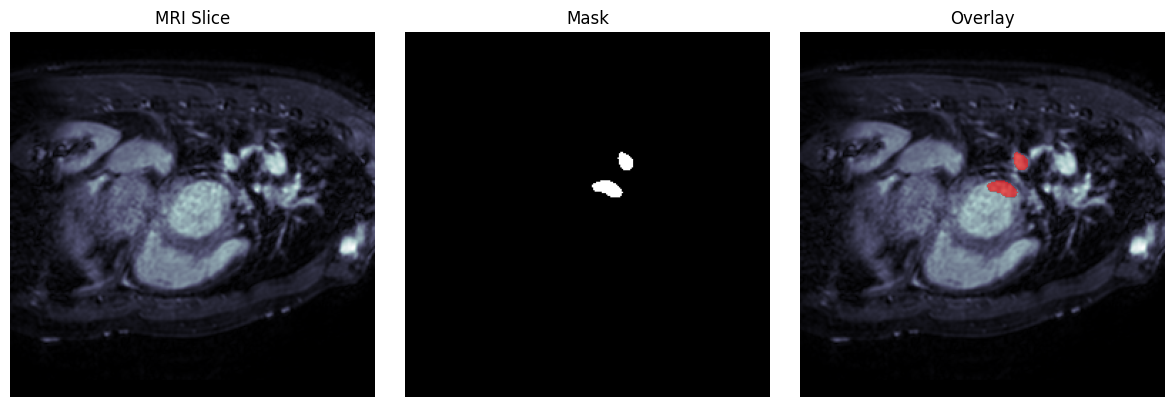

Slice shape: (256, 256)
Slice range: [0.000, 0.875]


In [14]:
# Verify preprocessing
sample_slice = np.load(PROCESSED_DIR / "train/0/data/50.npy")
sample_mask = np.load(PROCESSED_DIR / "train/0/masks/50.npy")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(sample_slice, cmap='bone')
axes[0].set_title('MRI Slice')
axes[0].axis('off')

axes[1].imshow(sample_mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

axes[2].imshow(sample_slice, cmap='bone')
mask_overlay = np.ma.masked_where(sample_mask == 0, sample_mask)
axes[2].imshow(mask_overlay, cmap='autumn', alpha=0.6)
axes[2].set_title('Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"Slice shape: {sample_slice.shape}")
print(f"Slice range: [{sample_slice.min():.3f}, {sample_slice.max():.3f}]")

---
<a id='part2'></a>
# Part 2: Dataset & Augmentation

## Why Augmentation Matters for Segmentation

With only ~20 subjects, we need aggressive augmentation to prevent overfitting.

**Key insight:** Image and mask must be augmented *identically*!
- If we rotate the MRI by 30°, the mask must rotate by exactly 30°
- Random crops must select the same region in both
- We use `imgaug` which handles this synchronization

**Augmentations we'll use:**

| Augmentation | Rationale |
|--------------|----------|
| **Rotation (±45°)** | Heart orientation varies between patients |
| **Scale (0.85-1.15×)** | Heart size varies |
| **Elastic deformation** | Simulates anatomical variation |


In [15]:
class CardiacDataset(torch.utils.data.Dataset):
    """
    PyTorch Dataset for cardiac MRI slices and segmentation masks.

    Handles:
    - Loading preprocessed numpy slices
    - Synchronized augmentation of image and mask
    - Proper tensor formatting for PyTorch
    """

    def __init__(self, root: Path, augment_params=None):
        """
        Args:
            root: Path to train/ or val/ directory
            augment_params: Albumentations Compose object (None for val)
        """
        self.all_files = self._extract_files(root)
        self.augment_params = augment_params
        print(f"Found {len(self.all_files)} slices in {root}")

    @staticmethod
    def _extract_files(root: Path) -> list:
        """Get paths to all slice files."""
        files = []
        for subject_dir in sorted(root.glob("*")):
            if subject_dir.is_dir():
                data_dir = subject_dir / "data"
                for slice_path in sorted(data_dir.glob("*.npy")):
                    files.append(slice_path)
        return files

    @staticmethod
    def _get_mask_path(slice_path: Path) -> Path:
        """Convert data path to masks path."""
        parts = list(slice_path.parts)
        parts[parts.index("data")] = "masks"
        return Path(*parts)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx: int):
        # Load slice and mask
        slice_path = self.all_files[idx]
        mask_path = self._get_mask_path(slice_path)

        image = np.load(slice_path).astype(np.float32)
        mask = np.load(mask_path)

        # Augment (training only)
        if self.augment_params is not None:
            augmented = self.augment_params(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Add channel dimension: (H, W) → (1, H, W)
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        return image, mask

In [17]:
# Define augmentation pipeline (Albumentations)
train_augmentation = A.Compose([
    A.Affine(
        scale=(0.85, 1.15),
        rotate=(-45, 45),
        p=1.0
    ),
    A.ElasticTransform(alpha=50, sigma=5, p=0.5),
])

In [18]:
# Create datasets
train_dataset = CardiacDataset(PROCESSED_DIR / "train", augment_params=train_augmentation)
val_dataset = CardiacDataset(PROCESSED_DIR / "val", augment_params=None)  # No augmentation for val!

Found 1932 slices in /content/Preprocessed/train
Found 339 slices in /content/Preprocessed/val


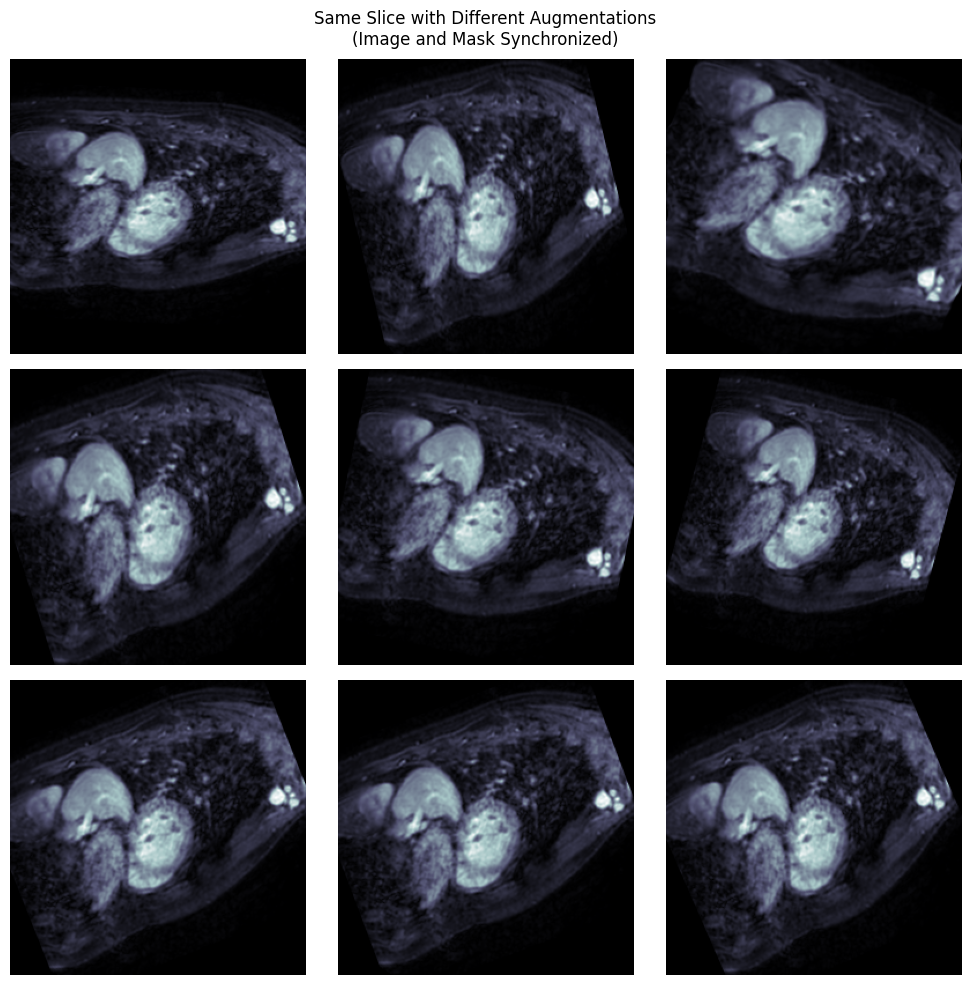

In [19]:
# Visualize augmentation (same slice, different augmentations)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Find a slice with visible left atrium
sample_idx = 50  # Adjust if needed

for i in range(3):
    for j in range(3):
        image, mask = train_dataset[sample_idx]

        axes[i, j].imshow(image[0], cmap='bone')
        mask_overlay = np.ma.masked_where(mask[0] == 0, mask[0])
        axes[i, j].imshow(mask_overlay, cmap='autumn', alpha=0.6)
        axes[i, j].axis('off')

plt.suptitle('Same Slice with Different Augmentations\n(Image and Mask Synchronized)', fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
# Create data loaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 242
Val batches: 43


---
<a id='part3'></a>
# Part 3: U-Net Architecture

## Why U-Net?

U-Net (Ronneberger et al., 2015) is *the* architecture for medical image segmentation. Key ideas:

1. **Encoder-Decoder structure**
   - Encoder: Extract features, reduce spatial resolution
   - Decoder: Reconstruct full-resolution segmentation

2. **Skip connections**
   - Connect encoder layers directly to decoder layers
   - Preserves fine-grained spatial information
   - Critical for precise boundaries

```
Input (256×256×1)
    ↓
  [Conv Block] → 64 channels ─────────────────────┐
    ↓ MaxPool                                      │
  [Conv Block] → 128 channels ────────────────┐   │
    ↓ MaxPool                                  │   │
  [Conv Block] → 256 channels ───────────┐    │   │
    ↓ MaxPool                             │    │   │
  [Conv Block] → 512 channels (bottleneck)│    │   │
    ↓ Upsample                            │    │   │
  [Conv Block] ← concat ──────────────────┘    │   │
    ↓ Upsample                                 │   │
  [Conv Block] ← concat ───────────────────────┘   │
    ↓ Upsample                                     │
  [Conv Block] ← concat ───────────────────────────┘
    ↓
  [1×1 Conv] → 1 channel
    ↓
Output (256×256×1)
```

In [21]:
class DoubleConv(nn.Module):
    """
    Double convolution block: (Conv → ReLU) × 2

    This is the basic building block used throughout U-Net.
    Two convolutions help extract richer features.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

In [22]:
class UNet(nn.Module):
    """
    U-Net for semantic segmentation.

    Architecture:
    - Encoder: 4 levels of downsampling (maxpool)
    - Decoder: 4 levels of upsampling (bilinear)
    - Skip connections at each level

    Input: (B, 1, 256, 256) grayscale image
    Output: (B, 1, 256, 256) segmentation logits
    """

    def __init__(self):
        super().__init__()

        # Encoder (downsampling path)
        self.enc1 = DoubleConv(1, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)  # Bottleneck

        # Decoder (upsampling path)
        # Note: input channels = upsampled + skip connection
        self.dec3 = DoubleConv(512 + 256, 256)
        self.dec2 = DoubleConv(256 + 128, 128)
        self.dec1 = DoubleConv(128 + 64, 64)

        # Final 1×1 conv to get single channel output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

        # Pooling and upsampling
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)           # (B, 64, 256, 256)
        e2 = self.enc2(self.pool(e1))  # (B, 128, 128, 128)
        e3 = self.enc3(self.pool(e2))  # (B, 256, 64, 64)
        e4 = self.enc4(self.pool(e3))  # (B, 512, 32, 32) - bottleneck

        # Decoder with skip connections
        d3 = self.upsample(e4)                    # (B, 512, 64, 64)
        d3 = torch.cat([d3, e3], dim=1)          # (B, 768, 64, 64)
        d3 = self.dec3(d3)                        # (B, 256, 64, 64)

        d2 = self.upsample(d3)                    # (B, 256, 128, 128)
        d2 = torch.cat([d2, e2], dim=1)          # (B, 384, 128, 128)
        d2 = self.dec2(d2)                        # (B, 128, 128, 128)

        d1 = self.upsample(d2)                    # (B, 128, 256, 256)
        d1 = torch.cat([d1, e1], dim=1)          # (B, 192, 256, 256)
        d1 = self.dec1(d1)                        # (B, 64, 256, 256)

        # Final layer (no activation - we'll apply sigmoid later)
        out = self.final(d1)                      # (B, 1, 256, 256)

        return out

In [23]:
# Test the architecture
model = UNet()
test_input = torch.randn(1, 1, 256, 256)
test_output = model(test_input)

print(f"Input shape:  {test_input.shape}")
print(f"Output shape: {test_output.shape}")
assert test_output.shape == test_input.shape, "Output shape should match input!"

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

Input shape:  torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])

Total parameters: 7,781,761


---
<a id='part4'></a>
# Part 4: Training & Evaluation

## Dice Loss

**Why not Cross-Entropy?**

In segmentation, most pixels are background. Cross-entropy would:
- Be dominated by easy background pixels
- Underweight the small foreground region

**Dice Loss** directly optimizes the overlap between prediction and ground truth:

$$\text{Dice} = \frac{2 |A \cap B|}{|A| + |B|}$$

$$\text{Dice Loss} = 1 - \text{Dice}$$

- Dice = 1.0 means perfect overlap
- Dice = 0.0 means no overlap
- Works well even with severe class imbalance

In [24]:
class DiceLoss(nn.Module):
    """
    Dice Loss for binary segmentation.

    Dice = 2 * |intersection| / (|pred| + |mask|)
    Loss = 1 - Dice
    """

    def __init__(self, smooth: float = 1e-8):
        super().__init__()
        self.smooth = smooth  # Prevent division by zero

    def forward(self, pred: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # Flatten predictions and masks
        pred = pred.view(-1)
        mask = mask.view(-1)

        # Compute Dice coefficient
        intersection = (pred * mask).sum()
        dice = (2.0 * intersection + self.smooth) / (pred.sum() + mask.sum() + self.smooth)

        return 1.0 - dice

In [25]:
class AtriumSegmentation(pl.LightningModule):
    """
    PyTorch Lightning module for left atrium segmentation.
    """

    def __init__(self, learning_rate: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()

        self.model = UNet()
        self.loss_fn = DiceLoss()
        self.learning_rate = learning_rate

    def forward(self, x):
        """Forward pass with sigmoid activation."""
        return torch.sigmoid(self.model(x))

    def training_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.float()

        preds = self(images)
        loss = self.loss_fn(preds, masks)

        # Log metrics
        dice_score = 1 - loss
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_dice', dice_score, prog_bar=True)

        # Log sample images periodically
        if batch_idx % 50 == 0:
            self._log_images(images, preds, masks, 'train')

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        masks = masks.float()

        preds = self(images)
        loss = self.loss_fn(preds, masks)

        dice_score = 1 - loss
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_dice', dice_score, prog_bar=True)

        if batch_idx % 5 == 0:
            self._log_images(images, preds, masks, 'val')

        return loss

    def _log_images(self, images, preds, masks, name):
        """Log sample predictions to TensorBoard."""
        # Threshold predictions
        preds_binary = (preds > 0.5).float()

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # Ground truth
        axes[0].imshow(images[0, 0].cpu(), cmap='bone')
        mask_gt = np.ma.masked_where(masks[0, 0].cpu() == 0, masks[0, 0].cpu())
        axes[0].imshow(mask_gt, alpha=0.6, cmap='autumn')
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')

        # Prediction
        axes[1].imshow(images[0, 0].cpu(), cmap='bone')
        mask_pred = np.ma.masked_where(preds_binary[0, 0].cpu() == 0, preds_binary[0, 0].cpu())
        axes[1].imshow(mask_pred, alpha=0.6, cmap='autumn')
        axes[1].set_title('Prediction')
        axes[1].axis('off')

        self.logger.experiment.add_figure(name, fig, self.global_step)
        plt.close(fig)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [28]:
# Initialize model
torch.manual_seed(42)
model = AtriumSegmentation(learning_rate=1e-4)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_dice',
    mode='max',
    save_top_k=3,
    filename='atrium-{epoch:02d}-{val_dice:.3f}'
)

# Trainer
trainer = pl.Trainer(
    max_epochs=50,  # 50 is enough for good results
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback],
    logger=TensorBoardLogger(save_dir='./logs', name='atrium'),
    log_every_n_steps=5
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


In [30]:
# Train!
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type     ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ UNet     │  7.8 M │ train │     0 │
│ 1 │ loss_fn │ DiceLoss │      0 │ train │     0 │
└───┴─────────┴──────────┴────────┴───────┴───────┘

Trainable params: 7.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 7.8 M                                                                                                
Total estimated model params size (MB): 31                                                                         
Modules in train mode: 47                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [31]:
# Best checkpoint
print(f"Best model: {checkpoint_callback.best_model_path}")
if checkpoint_callback.best_model_score is not None:
    print(f"Best val dice: {checkpoint_callback.best_model_score:.4f}")
else:
    print("No checkpoint saved — checking available checkpoints...")
    !ls -la ./logs/atrium/*/checkpoints/

Best model: ./logs/atrium/version_1/checkpoints/atrium-epoch=46-val_dice=0.605.ckpt
Best val dice: 0.6048


## Evaluation

In [32]:
# Load best model
best_model_path = checkpoint_callback.best_model_path
model = AtriumSegmentation.load_from_checkpoint(best_model_path)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [33]:
# Compute Dice score on full validation set
all_preds = []
all_masks = []

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        preds = model(images)
        all_preds.append(preds.cpu())
        all_masks.append(masks)

all_preds = torch.cat(all_preds)
all_masks = torch.cat(all_masks).float()

# Overall Dice score
dice_loss = DiceLoss()(all_preds, all_masks)
dice_score = 1 - dice_loss.item()

print(f"\nValidation Dice Score: {dice_score:.4f}")

Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]


Validation Dice Score: 0.9229


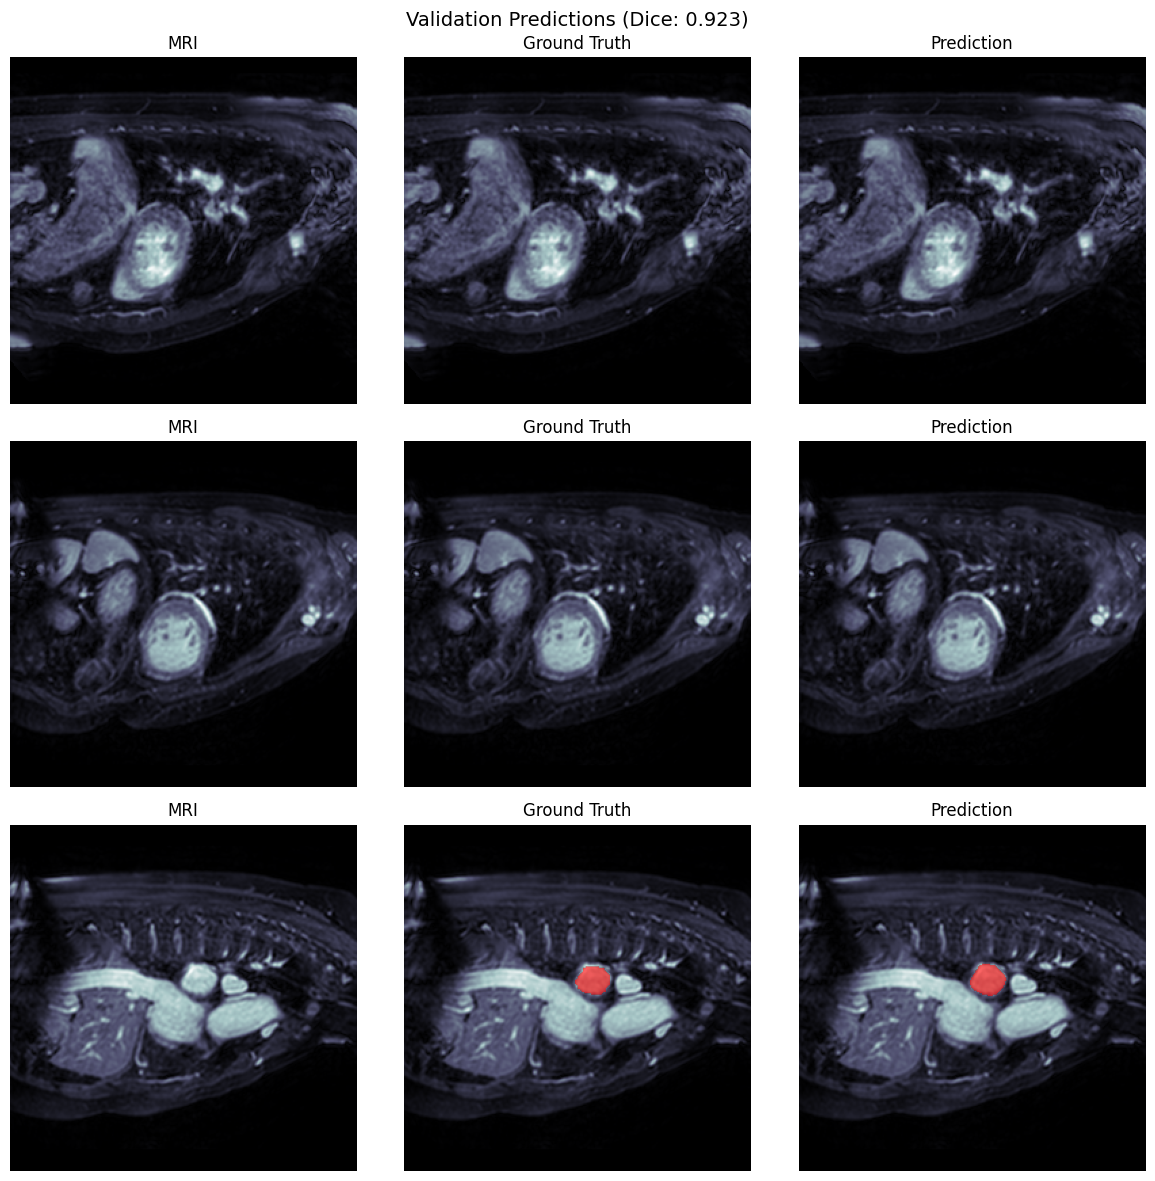

In [34]:
# Visualize predictions on validation samples
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax_row in enumerate(axes):
    idx = np.random.randint(0, len(val_dataset))
    image, mask = val_dataset[idx]

    # Predict
    with torch.no_grad():
        image_tensor = torch.tensor(image).unsqueeze(0).to(device)
        pred = model(image_tensor)[0, 0].cpu().numpy()
    pred_binary = pred > 0.5

    # Plot
    ax_row[0].imshow(image[0], cmap='bone')
    ax_row[0].set_title('MRI')
    ax_row[0].axis('off')

    ax_row[1].imshow(image[0], cmap='bone')
    mask_gt = np.ma.masked_where(mask[0] == 0, mask[0])
    ax_row[1].imshow(mask_gt, cmap='autumn', alpha=0.6)
    ax_row[1].set_title('Ground Truth')
    ax_row[1].axis('off')

    ax_row[2].imshow(image[0], cmap='bone')
    mask_pred = np.ma.masked_where(pred_binary == 0, pred_binary)
    ax_row[2].imshow(mask_pred, cmap='autumn', alpha=0.6)
    ax_row[2].set_title(f'Prediction')
    ax_row[2].axis('off')

plt.suptitle(f'Validation Predictions (Dice: {dice_score:.3f})', fontsize=14)
plt.tight_layout()
plt.show()

## Visualize Full 3D Volume Prediction

Let's run inference on a complete test volume and create an animation.

In [35]:
# Load a test subject (from imagesTs if available, otherwise use a train subject)
test_dir = DATA_ROOT / "imagesTs"
if test_dir.exists():
    test_file = list(test_dir.glob("*.nii.gz"))[0]
else:
    test_file = list(IMAGES_DIR.glob("*.nii.gz"))[0]

print(f"Loading: {test_file.name}")

# Load and preprocess
test_mri = nib.load(test_file).get_fdata()
test_mri = test_mri[32:-32, 32:-32, :]  # Crop
test_mri = standardize(normalize(test_mri))

print(f"Shape: {test_mri.shape}")

Loading: la_012.nii.gz
Shape: (256, 256, 137)


In [36]:
# Predict on each slice
predictions = []

model.eval()
with torch.no_grad():
    for i in tqdm(range(test_mri.shape[2]), desc="Predicting"):
        slice_2d = test_mri[:, :, i]
        slice_tensor = torch.tensor(slice_2d).unsqueeze(0).unsqueeze(0).float().to(device)
        pred = model(slice_tensor)[0, 0].cpu().numpy()
        predictions.append(pred > 0.5)

Predicting:   0%|          | 0/137 [00:00<?, ?it/s]

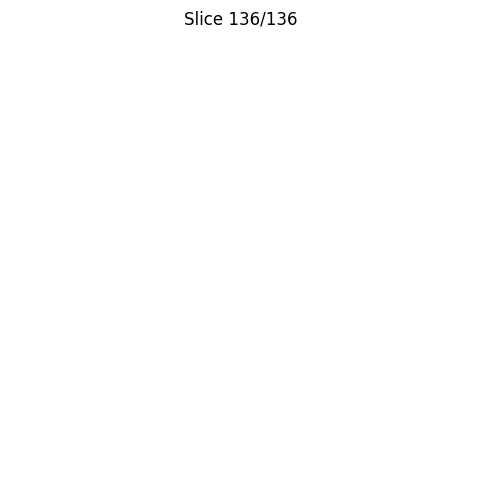

In [37]:
# Create animation
from celluloid import Camera
from IPython.display import HTML

fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)

for i in range(test_mri.shape[2]):
    plt.imshow(test_mri[:, :, i], cmap='bone')
    mask = np.ma.masked_where(predictions[i] == 0, predictions[i])
    plt.imshow(mask, alpha=0.5, cmap='autumn')
    plt.title(f'Slice {i}/{test_mri.shape[2]-1}')
    plt.axis('off')
    camera.snap()

animation = camera.animate(interval=100)
HTML(animation.to_html5_video())

---
# Summary

## What We Covered

| Topic | Key Points |
|-------|------------|
| **Data** | 3D NIfTI MRI → 2D slices, per-subject normalization |
| **Augmentation** | Synchronized image-mask transforms critical |
| **U-Net** | Encoder-decoder + skip connections = precise boundaries |
| **Dice Loss** | Handles class imbalance, directly optimizes overlap |

## Clinical Relevance

Left atrial segmentation is used for:
- Atrial fibrillation ablation planning
- LA volume measurement (cardiovascular risk factor)
- Pre-operative planning for cardiac procedures

## Next Steps

- **3D U-Net**: Process entire volume at once
- **Loss functions**: Focal loss, combined Dice + BCE
- **Post-processing**: Connected component analysis, morphological operations
- **Uncertainty**: Monte Carlo dropout for prediction confidence

---

